In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.evaluation import FBQA_Dataset, MetaQA_Dataset, CWQ_Dataset
from utils.graph import KGraphPreproc
from utils.preprocessing import preprocess_text
import networkx as nx
import ast

In [3]:
cwq_eval = CWQ_Dataset()
fbqa = FBQA_Dataset()
metaqa = MetaQA_Dataset()

In [104]:
cwq_eval.tabulate_performance()

CWQ
+-----------+------------+
| Method    |   Test Set |
+===========+============+
| bline     |      0.3   |
+-----------+------------+
| kb-path   |      0.621 |
+-----------+------------+
| kb1       |      0.291 |
+-----------+------------+
| kb2       |      0.302 |
+-----------+------------+
| kb3       |      0.301 |
+-----------+------------+
| sbert-kb1 |      0.241 |
+-----------+------------+
| sbert-kb2 |      0.226 |
+-----------+------------+
| sbert-kb3 |      0.217 |
+-----------+------------+


In [105]:
fbqa_stats = fbqa.tabulate_performance()

FBQA
+------------+------------+
| Method     |   Test Set |
+============+============+
| bline      |      0.773 |
+------------+------------+
| bline2     |      0.77  |
+------------+------------+
| kb-path    |      0.825 |
+------------+------------+
| kb1        |      0.757 |
+------------+------------+
| kb2        |      0.764 |
+------------+------------+
| kb3        |      0.757 |
+------------+------------+
| kb4        |      0.27  |
+------------+------------+
| kb5        |      0.215 |
+------------+------------+
| kb6        |      0.199 |
+------------+------------+
| kb7        |      0.063 |
+------------+------------+
| kb8        |      0.036 |
+------------+------------+
| kb9        |      0.015 |
+------------+------------+
| kb10       |      0.012 |
+------------+------------+
| kb11       |      0.004 |
+------------+------------+
| sbert-kb1  |      0.533 |
+------------+------------+
| sbert-kb2  |      0.59  |
+------------+------------+
| sbert-kb3  | 

KB performance is quite poor,
I would suppose that is due to:
1) over saturation with information, I had limit the number of triplets to 600 to avoid running out of memory
2) the triplets provided are 1hop away, whereas most questions have a long inference chain

TODO:
- investigate #hops/accuracy relationship for bline and kb1

TODO:
1. Make the search less static
2. Address the size issue (neighbour order = size explosion)

Potentially:
1. Do RAG
2. Rerank Chunks
2. From the top chunks, extract triplets and continue

Project Structure:
1. Baseline (have a stable vanilla answer)
2. KG integration (shown the improvement)
3. Constructing the KB (how to quantify construction performance)
4. Using the KB (dynamic exploration)

## FBQA hop accuracy exploration

In [106]:
fbqa.answers

0      [terry gilliam, terry gilliam, terry gilliam, ...
1                                     [germany, germany]
2                                         [adolf hitler]
3      [ernest hemingway, ernest hemingway, ernest he...
4             [dick fosbury, dick fosbury, dick fosbury]
                             ...                        
995                                     [woodrow wilson]
996                                 [sylvester stallone]
997                                         [whitehorse]
998                          [short track speed skating]
999                               [salisbury, salisbury]
Length: 1000, dtype: object

In [5]:
fbqa.test_set

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities
2,FreebaseQA-eval-2,Who directed the films; The Fisher King (1991)...,who directed the films; the fisher king (1991)...,"[{'Parse-Id': 'FreebaseQA-eval-2.P0', 'Potenti...","[['/m/07j6w', '/m/07h5d'], ['/m/04z257', '/m/0..."
5,FreebaseQA-eval-5,Which country hosted the 1936 Summer Olympic G...,which country hosted the 1936 summer olympic g...,"[{'Parse-Id': 'FreebaseQA-eval-5.P0', 'Potenti...","[['/m/09x3r', '/m/0345h'], ['/m/09x3r', '/m/03..."
6,FreebaseQA-eval-6,Who declared the 1936 summer Olympic Games ope...,who declared the 1936 summer olympic games ope...,"[{'Parse-Id': 'FreebaseQA-eval-6.P0', 'Potenti...","[['/m/09x3r', '/m/07_m9_']]"
9,FreebaseQA-eval-9,Which US author won the 1953 Pulitzer Prize fo...,which us author won the 1953 pulitzer prize fo...,"[{'Parse-Id': 'FreebaseQA-eval-9.P0', 'Potenti...","[['/m/0tjss_k', '/m/02kz_'], ['/m/015dlb', '/m..."
12,FreebaseQA-eval-12,Which US athlete won a gold medal for the high...,which us athlete won a gold medal for the high...,"[{'Parse-Id': 'FreebaseQA-eval-12.P0', 'Potent...","[['/m/0l998', '/m/01_96x'], ['/m/02lpp7', '/m/..."
...,...,...,...,...,...
3964,FreebaseQA-eval-3964,Who was president of the USA at the outbreak o...,who was president of the usa at the outbreak o...,"[{'Parse-Id': 'FreebaseQA-eval-3964.P0', 'Pote...","[['/m/0cm2xh', '/m/083q7']]"
3969,FreebaseQA-eval-3969,Which actor has won a 'Golden Raspberry' award...,which actor has won a 'golden raspberry' award...,"[{'Parse-Id': 'FreebaseQA-eval-3969.P0', 'Pote...","[['/m/07cbcy', '/m/0gn30']]"
3985,FreebaseQA-eval-3985,What is the capital of the Yukon Territory in ...,what is the capital of the yukon territory in ...,"[{'Parse-Id': 'FreebaseQA-eval-3985.P0', 'Pote...","[['/m/087r4', '/m/081s7']]"
3993,FreebaseQA-eval-3993,"Zhou Yang, gold medal winner at the Winter Oly...","zhou yang, gold medal winner at the winter oly...","[{'Parse-Id': 'FreebaseQA-eval-3993.P0', 'Pote...","[['/m/03wctx_', '/m/09_bl']]"


In [107]:
fbkb = KGraphPreproc.get_fbkb_graph()

In [108]:
def entity_path_len(entities):
    for path in entities:
        start = path[0]
        for target in path[1:]:
            try:
                return len(nx.shortest_path(
                    fbkb._graph, start, target
                ))
            except (nx.NodeNotFound, nx.NetworkXNoPath):
                continue
    return -1

In [110]:
fbqa_tset = fbqa.test_set.copy()
fbqa_tset["Answer"] = fbqa.answers.values
fbqa_tset["entities"] = fbqa_tset["entities"].apply(ast.literal_eval)
fbqa_tset["hops"] = fbqa_tset.apply(lambda t: entity_path_len(t["entities"]), axis=1)
# fbqa_tset = fbqa_tset[fbqa_tset["hops"] != 10]
# fbqa_tset.drop(columns=["Dataset", "Version", "Questions"], inplace=True)
fbqa_tset

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities,Answer,hops
2,FreebaseQA-eval-2,Who directed the films; The Fisher King (1991)...,who directed the films; the fisher king (1991)...,"[{'Parse-Id': 'FreebaseQA-eval-2.P0', 'Potenti...","[[/m/07j6w, /m/07h5d], [/m/04z257, /m/07h5d], ...","[terry gilliam, terry gilliam, terry gilliam, ...",2
5,FreebaseQA-eval-5,Which country hosted the 1936 Summer Olympic G...,which country hosted the 1936 summer olympic g...,"[{'Parse-Id': 'FreebaseQA-eval-5.P0', 'Potenti...","[[/m/09x3r, /m/0345h], [/m/09x3r, /m/0345h]]","[germany, germany]",2
6,FreebaseQA-eval-6,Who declared the 1936 summer Olympic Games ope...,who declared the 1936 summer olympic games ope...,"[{'Parse-Id': 'FreebaseQA-eval-6.P0', 'Potenti...","[[/m/09x3r, /m/07_m9_]]",[adolf hitler],3
9,FreebaseQA-eval-9,Which US author won the 1953 Pulitzer Prize fo...,which us author won the 1953 pulitzer prize fo...,"[{'Parse-Id': 'FreebaseQA-eval-9.P0', 'Potenti...","[[/m/0tjss_k, /m/02kz_], [/m/015dlb, /m/02kz_]...","[ernest hemingway, ernest hemingway, ernest he...",2
12,FreebaseQA-eval-12,Which US athlete won a gold medal for the high...,which us athlete won a gold medal for the high...,"[{'Parse-Id': 'FreebaseQA-eval-12.P0', 'Potent...","[[/m/0l998, /m/01_96x], [/m/02lpp7, /m/01_96x]...","[dick fosbury, dick fosbury, dick fosbury]",5
...,...,...,...,...,...,...,...
3964,FreebaseQA-eval-3964,Who was president of the USA at the outbreak o...,who was president of the usa at the outbreak o...,"[{'Parse-Id': 'FreebaseQA-eval-3964.P0', 'Pote...","[[/m/0cm2xh, /m/083q7]]",[woodrow wilson],2
3969,FreebaseQA-eval-3969,Which actor has won a 'Golden Raspberry' award...,which actor has won a 'golden raspberry' award...,"[{'Parse-Id': 'FreebaseQA-eval-3969.P0', 'Pote...","[[/m/07cbcy, /m/0gn30]]",[sylvester stallone],2
3985,FreebaseQA-eval-3985,What is the capital of the Yukon Territory in ...,what is the capital of the yukon territory in ...,"[{'Parse-Id': 'FreebaseQA-eval-3985.P0', 'Pote...","[[/m/087r4, /m/081s7]]",[whitehorse],6
3993,FreebaseQA-eval-3993,"Zhou Yang, gold medal winner at the Winter Oly...","zhou yang, gold medal winner at the winter oly...","[{'Parse-Id': 'FreebaseQA-eval-3993.P0', 'Pote...","[[/m/03wctx_, /m/09_bl]]",[short track speed skating],5


[ 2  3  5  4  9  8  7  6 10]


<Axes: >

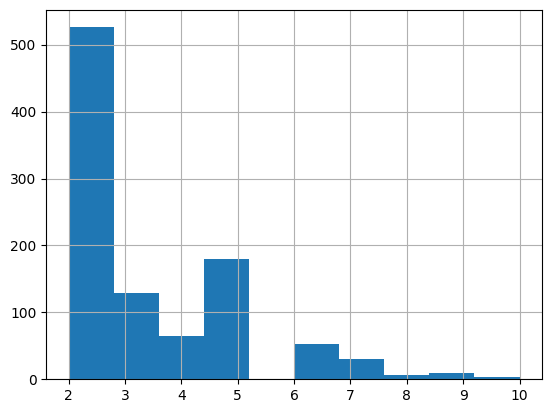

In [111]:
print(fbqa_tset.hops.unique())
fbqa_tset.hops.hist()

In [112]:
fbqa_tset.fillna("", inplace=True)
fbqa_tset.tail()

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities,Answer,hops
3964,FreebaseQA-eval-3964,Who was president of the USA at the outbreak o...,who was president of the usa at the outbreak o...,"[{'Parse-Id': 'FreebaseQA-eval-3964.P0', 'Pote...","[[/m/0cm2xh, /m/083q7]]",[woodrow wilson],2
3969,FreebaseQA-eval-3969,Which actor has won a 'Golden Raspberry' award...,which actor has won a 'golden raspberry' award...,"[{'Parse-Id': 'FreebaseQA-eval-3969.P0', 'Pote...","[[/m/07cbcy, /m/0gn30]]",[sylvester stallone],2
3985,FreebaseQA-eval-3985,What is the capital of the Yukon Territory in ...,what is the capital of the yukon territory in ...,"[{'Parse-Id': 'FreebaseQA-eval-3985.P0', 'Pote...","[[/m/087r4, /m/081s7]]",[whitehorse],6
3993,FreebaseQA-eval-3993,"Zhou Yang, gold medal winner at the Winter Oly...","zhou yang, gold medal winner at the winter oly...","[{'Parse-Id': 'FreebaseQA-eval-3993.P0', 'Pote...","[[/m/03wctx_, /m/09_bl]]",[short track speed skating],5
3994,FreebaseQA-eval-3994,"Also the name of an English city, Harare, the ...","also the name of an english city, harare, the ...","[{'Parse-Id': 'FreebaseQA-eval-3994.P0', 'Pote...","[[/m/088q4, /m/0fngf], [/m/088q4, /m/0fngf]]","[salisbury, salisbury]",2


In [113]:
# load model answers
for r_set in fbqa.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    result_df = pd.read_csv(r_set)
    values = result_df.Model.apply(str).apply(str.lower).apply(lambda t: t.split(",")).values
    values = np.pad(values, (0, 1000 - values.size), constant_values="")
    fbqa_tset[set_name] = values
    fbqa_tset[f"{set_name}_rouge-l"] = fbqa_tset.apply(lambda t: fbqa.get_rouge_score_for_answers(t.Answer, t[set_name]), axis=1)
    fbqa_tset[f"{set_name}_correct"] = fbqa_tset.apply(lambda t: t[f"{set_name}_rouge-l"] >= 0.5, axis=1)
fbqa_tset.head()

,Question-ID,RawQuestion,ProcessedQuestion,Parses,entities,Answer,hops,bline,bline_rouge-l,bline_correct,...,sbert-kb9_correct,sbert-kb10,sbert-kb10_rouge-l,sbert-kb10_correct,sbert-kb11,sbert-kb11_rouge-l,sbert-kb11_correct,tog-lp-1,tog-lp-1_rouge-l,tog-lp-1_correct
2,FreebaseQA-eval-2,Who directed the films; The Fisher King (1991)...,who directed the films; the fisher king (1991)...,"[{'Parse-Id': 'FreebaseQA-eval-2.P0', 'Potenti...","[[/m/07j6w, /m/07h5d], [/m/04z257, /m/07h5d], ...","[terry gilliam, terry gilliam, terry gilliam, ...",2,[terry gilliam],1.0,True,...,False,[nan],0.0,False,[nan],0.0,False,"[('terry gilliam', 3)]",0.0,False
5,FreebaseQA-eval-5,Which country hosted the 1936 Summer Olympic G...,which country hosted the 1936 summer olympic g...,"[{'Parse-Id': 'FreebaseQA-eval-5.P0', 'Potenti...","[[/m/09x3r, /m/0345h], [/m/09x3r, /m/0345h]]","[germany, germany]",2,[germany],1.0,True,...,False,[nan],0.0,False,[nan],0.0,False,"[('germany', 1)]",0.0,False
6,FreebaseQA-eval-6,Who declared the 1936 summer Olympic Games ope...,who declared the 1936 summer olympic games ope...,"[{'Parse-Id': 'FreebaseQA-eval-6.P0', 'Potenti...","[[/m/09x3r, /m/07_m9_]]",[adolf hitler],3,[adolf hitler and carl diem declared the 1936 ...,1.0,True,...,False,[nan],0.0,False,[nan],0.0,False,"[('adolf hitler and carl diem', 3)]",0.5,True
9,FreebaseQA-eval-9,Which US author won the 1953 Pulitzer Prize fo...,which us author won the 1953 pulitzer prize fo...,"[{'Parse-Id': 'FreebaseQA-eval-9.P0', 'Potenti...","[[/m/0tjss_k, /m/02kz_], [/m/015dlb, /m/02kz_]...","[ernest hemingway, ernest hemingway, ernest he...",2,[ernest hemingway],1.0,True,...,False,[nan],0.0,False,[nan],0.0,False,"[('john steinbeck', 1)]",0.0,False
12,FreebaseQA-eval-12,Which US athlete won a gold medal for the high...,which us athlete won a gold medal for the high...,"[{'Parse-Id': 'FreebaseQA-eval-12.P0', 'Potent...","[[/m/0l998, /m/01_96x], [/m/02lpp7, /m/01_96x]...","[dick fosbury, dick fosbury, dick fosbury]",5,[dick fosbury (introduced the fosbury flop)],1.0,True,...,False,[nan],0.0,False,[nan],0.0,False,"[('dick fosbury (united states of america)', 1)]",0.5,True


In [114]:
fbqa_tset = fbqa_tset[fbqa_tset["hops"] != 10]

In [115]:
fbqa_tset.loc[2658]["kb-path"]

['moon', ' natural satellite']

In [116]:
fbqa_tset[fbqa_tset["hops"] == 8][["RawQuestion", "Answer", "bline", "kb-path", "kb-path_rouge-l"]]

,RawQuestion,Answer,bline,kb-path,kb-path_rouge-l
121,"The Romanov Dynasty (Peter I, Catherine I, Pet...","[russia, russia, russia, russia, russia]",[russia],[russia],1.0
377,Who composed La Peri (in ballet)?,"[paul dukas, paul dukas]",[jules massenet composed la peri (in ballet).],[not provided in the context.],0.0
763,Who was elected Prime Minister of Canada in 1921?,"[william lyon mackenzie king, william lyon mac...",[william lyon mackenzie king],[the given context does not provide informatio...,0.0
1544,What country contains most of the Ganges river...,[bangladesh],[india],[bangladesh],1.0
2658,What is the name for a natural satellite that ...,[moon],[moon (for earth's natural satellite)\r\n\r\nh...,"[moon, natural satellite]",1.0
2854,What river flows through Paris?,"[seine, seine]",[seine river],[no river flows through paris.],0.0


In [117]:
set_names = [r.split("/")[-1].split(".")[0] for r in fbqa.result_set_paths]
set_names

['bline',
 'bline2',
 'kb-path',
 'kb1',
 'kb2',
 'kb3',
 'kb4',
 'kb5',
 'kb6',
 'kb7',
 'kb8',
 'kb9',
 'kb10',
 'kb11',
 'sbert-kb1',
 'sbert-kb2',
 'sbert-kb3',
 'sbert-kb4',
 'sbert-kb5',
 'sbert-kb6',
 'sbert-kb7',
 'sbert-kb8',
 'sbert-kb9',
 'sbert-kb10',
 'sbert-kb11',
 'tog-lp-1']

In [118]:
fbqa_res = fbqa_tset[["hops", *[s+"_correct" for s in set_names]]]
fbqa_res.head()

,hops,bline_correct,bline2_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,kb4_correct,kb5_correct,kb6_correct,...,sbert-kb3_correct,sbert-kb4_correct,sbert-kb5_correct,sbert-kb6_correct,sbert-kb7_correct,sbert-kb8_correct,sbert-kb9_correct,sbert-kb10_correct,sbert-kb11_correct,tog-lp-1_correct
2,2,True,True,True,True,True,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
5,2,True,True,True,True,True,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
6,3,True,True,True,True,True,True,True,False,False,...,True,True,False,False,False,False,False,False,False,True
9,2,True,True,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,5,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,True


In [119]:
hop_stats = fbqa_res.groupby(by="hops").sum()
hop_stats["total"] = fbqa_res.groupby(by="hops").apply(lambda t: len(t))
for rset in set_names:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_correct"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_3463/1450273462.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = fbqa_res.groupby(by="hops").apply(lambda t: len(t))


,bline_correct,bline2_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,kb4_correct,kb5_correct,kb6_correct,kb7_correct,...,sbert-kb3_p,sbert-kb4_p,sbert-kb5_p,sbert-kb6_p,sbert-kb7_p,sbert-kb8_p,sbert-kb9_p,sbert-kb10_p,sbert-kb11_p,tog-lp-1_p
hops,,,,,,,,,,,,,,,,,,,,,
2,416,416,477,413,421,417,0,0,0,0,...,0.591,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.080
3,95,95,95,88,91,88,89,0,0,0,...,0.620,0.628,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.031
4,43,43,47,40,40,42,42,40,0,0,...,0.422,0.391,0.453,0.000,0.000,0.000,0.000,0.000,0.0,0.047
5,143,142,135,140,137,136,139,138,141,0,...,0.620,0.665,0.631,0.626,0.000,0.000,0.000,0.000,0.0,0.034
6,37,37,36,37,36,34,0,37,35,36,...,0.528,0.000,0.509,0.528,0.528,0.000,0.000,0.000,0.0,0.075
7,23,21,23,22,23,23,0,0,23,23,...,0.733,0.000,0.000,0.667,0.700,0.633,0.000,0.000,0.0,0.200
8,4,4,3,5,4,5,0,0,0,4,...,0.667,0.000,0.000,0.000,0.667,0.667,0.667,0.000,0.0,0.167
9,8,8,5,8,8,8,0,0,0,0,...,0.556,0.000,0.000,0.000,0.000,0.667,0.667,0.667,0.0,0.000


In [120]:
print("FBQA")
data = hop_stats[["total", *[s+"_p" for s in set_names]]]
data

FBQA


,total,bline_p,bline2_p,kb-path_p,kb1_p,kb2_p,kb3_p,kb4_p,kb5_p,kb6_p,...,sbert-kb3_p,sbert-kb4_p,sbert-kb5_p,sbert-kb6_p,sbert-kb7_p,sbert-kb8_p,sbert-kb9_p,sbert-kb10_p,sbert-kb11_p,tog-lp-1_p
hops,,,,,,,,,,,,,,,,,,,,,
2,526,0.791,0.791,0.907,0.785,0.800,0.793,0.000,0.000,0.000,...,0.591,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.080
3,129,0.736,0.736,0.736,0.682,0.705,0.682,0.690,0.000,0.000,...,0.620,0.628,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.031
4,64,0.672,0.672,0.734,0.625,0.625,0.656,0.656,0.625,0.000,...,0.422,0.391,0.453,0.000,0.000,0.000,0.000,0.000,0.0,0.047
5,179,0.799,0.793,0.754,0.782,0.765,0.760,0.777,0.771,0.788,...,0.620,0.665,0.631,0.626,0.000,0.000,0.000,0.000,0.0,0.034
6,53,0.698,0.698,0.679,0.698,0.679,0.642,0.000,0.698,0.660,...,0.528,0.000,0.509,0.528,0.528,0.000,0.000,0.000,0.0,0.075
7,30,0.767,0.700,0.767,0.733,0.767,0.767,0.000,0.000,0.767,...,0.733,0.000,0.000,0.667,0.700,0.633,0.000,0.000,0.0,0.200
8,6,0.667,0.667,0.500,0.833,0.667,0.833,0.000,0.000,0.000,...,0.667,0.000,0.000,0.000,0.667,0.667,0.667,0.000,0.0,0.167
9,9,0.889,0.889,0.556,0.889,0.889,0.889,0.000,0.000,0.000,...,0.556,0.000,0.000,0.000,0.000,0.667,0.667,0.667,0.0,0.000


In [121]:
def get_n_data(data, set_name, delta=0):
    return [
        data.loc[hop, f"{set_name}{int(hop)+delta}_p"]
        for hop in data.index
    ]

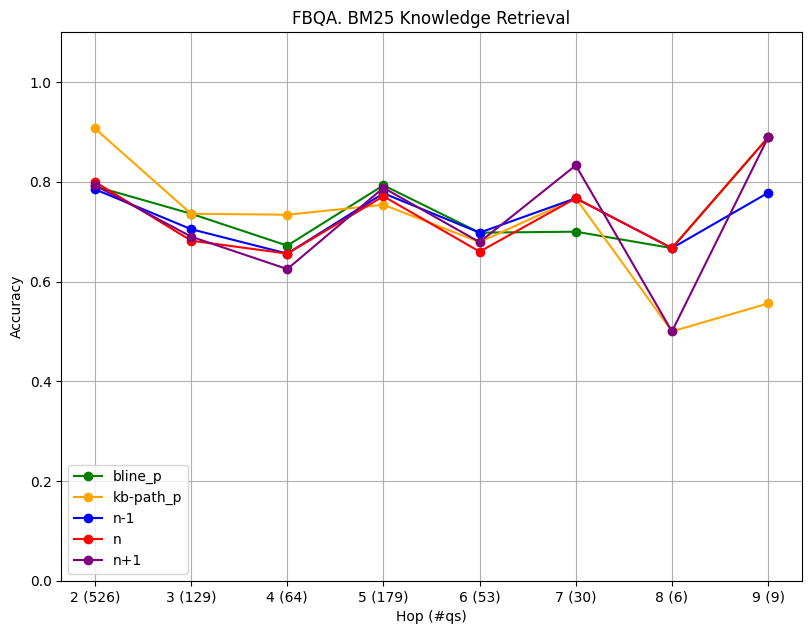

In [122]:
colors = {
    "bline_p": "green",
    "kb-path_p": "orange",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
    "tog-lp-1": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, ax = plt.subplots(figsize=(8, 6))
lines = [
    
]

nm1_data = get_n_data(data, "kb", -1)
ndata = get_n_data(data, "kb", 0)
np1_data = get_n_data(data, "kb", 1)
datas = {
    "bline_p": data["bline2_p"].values,
    "kb-path_p": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data,
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("FBQA. BM25 Knowledge Retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


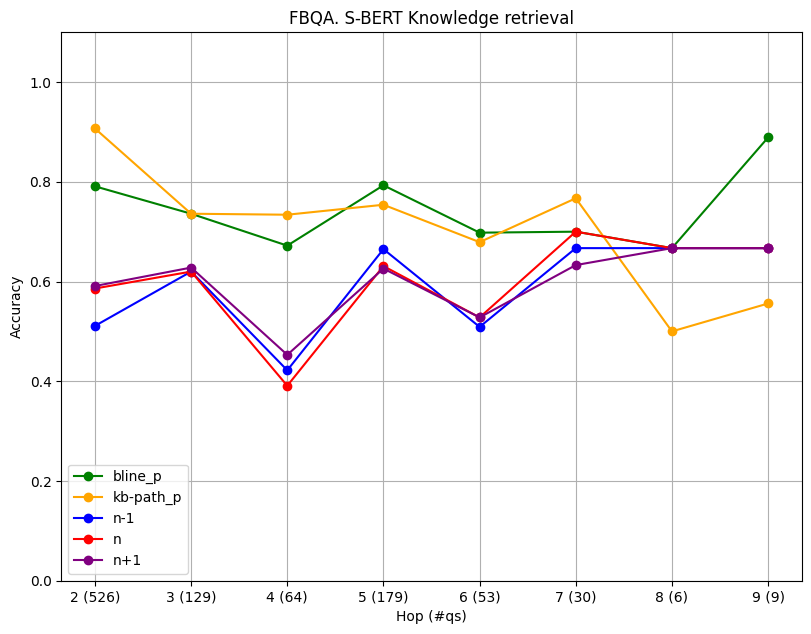

In [98]:
colors = {
    "bline_p": "green",
    "kb-path_p": "orange",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, ax = plt.subplots(figsize=(8, 6))
lines = [
    
]

nm1_data = get_n_data(data, "sbert-kb", -1)
ndata = get_n_data(data, "sbert-kb", 0)
np1_data = get_n_data(data, "sbert-kb", 1)
datas = {
    "bline_p": data["bline2_p"].values,
    "kb-path_p": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("FBQA. S-BERT Knowledge retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


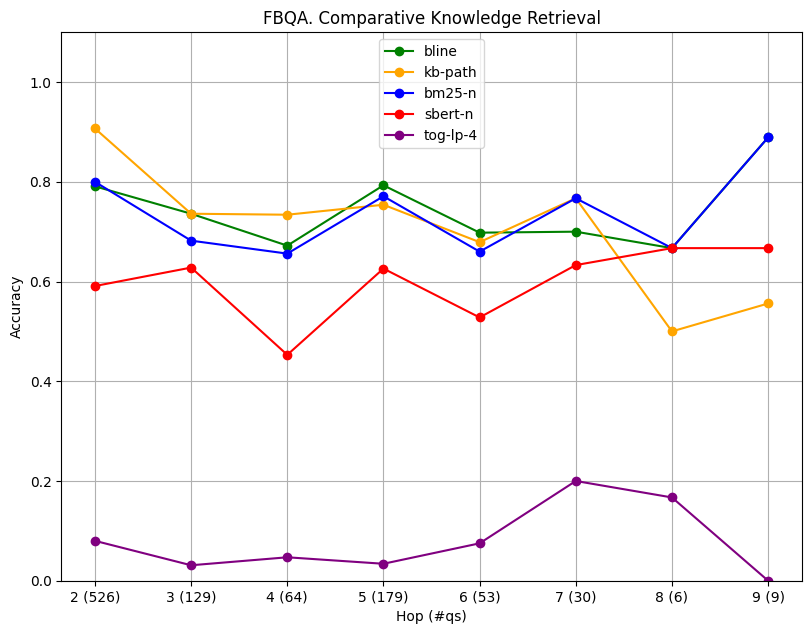

In [124]:
# "": data["tog-lp-1_p"].values
colors = {
    "bline": "green",
    "kb-path": "orange",
    "bm25-n": "blue",
    "sbert-n": "red",
    "tog-lp-4": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, ax = plt.subplots(figsize=(8, 6))
lines = [
    
]


bm25 = get_n_data(data, "kb", 0)
sbert = get_n_data(data, "sbert-kb", 1)

datas = {
    "bline": data["bline2_p"].values,
    "kb-path": data["kb-path_p"].values,
    "bm25-n": bm25,
    "sbert-n": sbert,
    "tog-lp-4": data["tog-lp-1_p"]
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("FBQA. Comparative Knowledge Retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


## 18.02.2025:


Trade-off between:
- Internal knowledge
- Amount of introduced data

Delicate balance: introducing knowledge initially shadows the internal knowledge, but given correctly retrieved knowledge, the accuracy is good

Bias towards training data [link](https://proceedings.neurips.cc/paper_files/paper/2024/file/2a617efee5815f12b405d40569dea0a5-Paper-Datasets_and_Benchmarks_Track.pdf)



### TODO: Directly do 7 hops (n-1, n, n+1)

Models may vary in their bias towards certain data in specific domains

As a consequence: the ideal solution is to provide relevant knowledge with relationships and biases accounted for.

^ That's a way of addressing the issue
The idea is to minimize the bias introduced in training data (possibly by introducing data ONLY relevant to the subject and therefore overriding the internal bias)

## By Tuesday (25.02), do the 

- Intro
- related work (finem)

- preliminary data
- graph
- model
- baseline bias
- talk about the results
- kb results


- why worth looking into knowledge bases (literature + numbers)

- Given the justification and the pattern holding, introduce the need for a retrieval technique

- link prediction, tail pruning

- consider answering on an explicit path (would it still answer correctly)